<a href="https://colab.research.google.com/github/vanviethieuanh/CS114.L21/blob/main/Predict_Final_Exam_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CS114.L21 - MACHINE LEARNING**

# Colaboratory (17/05/2021)

+ [Assignment's Github](https://github.com/vanviethieuanh/CS114.L21/blob/main/Predict_the_final_score_of_students_IT001.ipynb)

+ [GitHub dataset](https://drive.google.com/drive/folders/1WHVKhGP-z7mJg8B8HumeRqS10c-RUYhu?usp=sharing)

**1. Requirements:** Data discovery

**2. Team Members**

| Tên               | Mã số sinh viên |
| ----------------- | --------------- |
| Nguyễn Đại Kỳ     | 19521731        |
| Văn Viết Hiếu Anh | 19521225        |
| Lê Văn Phước      | 19522054        |

**3. Reference Material**

- About how to imputation missing data:

  - [git@github.com:matthewbrems/missing-data-workshop.git](https://github.com/matthewbrems/missing-data-workshop?fbclid=IwAR1LGjaIen-ITLndPN1ODV1lYZBvxsHDs0DgIaPkuxpXMsQRBT8eAPI-0sI)

  - [Data Imputation: Beyond Mean, Median, and Mode](https://medium.com/@ODSC/data-imputation-beyond-mean-median-and-mode-6c798f3212e3)

- About comparison of regression libraries:

  - [Difference between statsmodel OLS and scikit linear regression](https://stats.stackexchange.com/questions/146804/difference-between-statsmodel-ols-and-scikit-linear-regression)

- Usage of libraries: [Seaborn](https://seaborn.pydata.org/), [Regression in scikit-learn](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), [Statsmodels API](https://www.statsmodels.org/stable/api.html), [Pandas](https://pandas.pydata.org/)

**4. Dataset and Test size**:
- Dataset: 853 entries
- Test size: 30% (256 entries)

In [1]:
# To visualize data.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# To read and store data.
import numpy
import pandas as pd

# Shuffle and split data
from sklearn.model_selection import train_test_split

# To fit linear regression model and show metrics
# sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# statsmodels
import statsmodels.api as sm

# To normalize data
from sklearn.preprocessing import StandardScaler

# Install and import missinIIno to visualize missingness patterns. (Uncomment first line to install missingno.)
!pip3 install missingno
import missingno as msno

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

# To join multiple table
from functools import reduce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import data
df_wecode = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/wecode.csv')
df_score_training = pd.read_csv('https://raw.githubusercontent.com/vanviethieuanh/CS114.L21/main/score_training.csv')

# Pre-processing

## Import parse

In [3]:
# Parse created_at and updated_at to date form
parse_cols = ['created_at','updated_at']
df_wecode[parse_cols] = df_wecode[parse_cols].apply(pd.to_datetime)

# Parse score to numerical data
parse_cols = ['QT','GK','TH','CK','TBM','TBTL']
df_score_training[parse_cols] = df_score_training[parse_cols].apply(pd.to_numeric, downcast='float', errors='coerce')

## Data overview



### wecode table (264.606 entries)

| #    | Column        | Missing (%)       | Data type | Distinct |
| ---- | ------------- | ----------------- | --------- | -------- |
| 0    | id            | 0                 | int64     | 264606   |
| 1    | assignment_id | 0                 | int64     | 290      |
| 2    | problem_id    | 0                 | int64     | 634      |
| 3    | user_id       | 0                 | int64     | 1159     |
| 4    | is_final      | 0                 | int64     | 2        |
| 5    | status        | 0.000377920379734 | object    | 4        |
| 6    | pre_score     | 0                 | int64     | 473      |
| 7    | coefficient   | 0                 | object    | 129      |
| 8    | file_name     | 0                 | object    | 9242     |
| 9    | language_id   | 0                 | int64     | 2        |
| 10   | created_at    | 0                 | object    | 255922   |
| 11   | updated_at    | 0                 | object    | 217694   |

In [4]:
df_wecode.head(10)

,id,assignment_id,problem_id,user_id,is_final,status,pre_score,coefficient,file_name,language_id,created_at,updated_at
0,4,0,3,4,1,SCORE,10000,100,solution-0,2,2020-10-30 10:58:11,2020-10-30 10:58:19
1,5,0,4,4,1,SCORE,10000,100,solution-1,2,2020-10-30 11:07:09,2020-10-30 11:07:17
2,6,0,5,4,0,Compilation Error,0,100,solution-2,2,2020-10-30 11:08:01,2020-10-30 11:23:36
3,7,0,5,4,0,Compilation Error,0,100,solution-3,2,2020-10-30 11:11:41,2020-10-30 11:11:42
4,8,0,5,4,0,Compilation Error,0,100,solution-4,2,2020-10-30 11:15:06,2020-10-30 11:15:07
5,9,0,5,4,0,Compilation Error,0,100,solution-5,2,2020-10-30 11:16:57,2020-10-30 11:16:58
6,10,0,6,4,1,SCORE,10000,100,solution-6,2,2020-10-30 11:18:47,2020-10-30 11:18:55
7,11,0,7,4,1,SCORE,10000,100,solution-7,2,2020-10-30 11:20:07,2020-10-30 11:20:15
8,12,0,8,4,1,SCORE,10000,100,solution-8,2,2020-10-30 11:21:02,2020-10-30 11:21:10
9,13,0,9,4,1,SCORE,10000,100,solution-9,2,2020-10-30 11:21:36,2020-10-30 11:21:44


### score table (975 entries)

| #    | Column | Missing (%) | Data type | Distinct |
| ---- | ------ | ----------- | --------- | -------- |
| 0    | id     | 0(0%)       | int64     | 975      |
| 1    | QT     | 84(8.62%)   | float32   | 21       |
| 2    | GK     | 139(14.26%) | float32   | 21       |
| 3    | TH     | 83(8.51%)   | float32   | 21       |
| 4    | CK     | 55(5.64%)   | float32   | 21       |
| 5    | TBM    | 189(19.38%) | float32   | 87       |
| 6    | TBTL   | 3(0.31%)    | float32   | 433      |

In [5]:
df_score_training

,id,QT,GK,TH,CK,TBM,TBTL
0,22,10.0,9.0,8.5,8.5,8.8,8.52
1,24,10.0,8.0,10.0,9.5,9.4,8.41
2,27,10.0,10.0,10.0,10.0,10.0,8.67
3,28,10.0,9.5,7.5,9.5,9.2,7.39
4,29,10.0,9.5,5.0,8.5,8.2,8.05
...,...,...,...,...,...,...,...
970,1857,5.0,4.5,10.0,4.0,6.0,6.03
971,1859,8.0,5.0,10.0,1.5,5.4,5.06
972,1862,5.0,6.5,1.0,7.5,5.1,4.71
973,1865,6.5,NaN,3.0,7.5,NaN,6.89


**Visualize missing data**

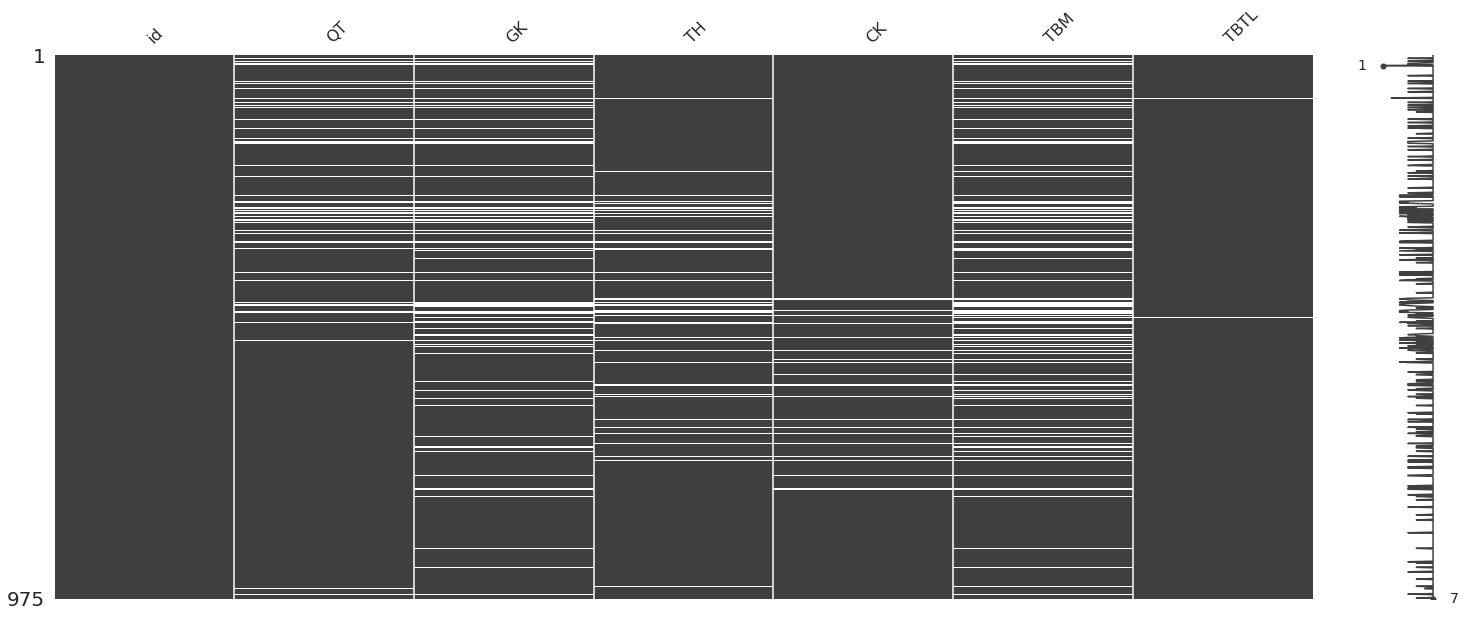

In [6]:
msno.matrix(df_score_training)

## Data Imputation

### Comparison of methods

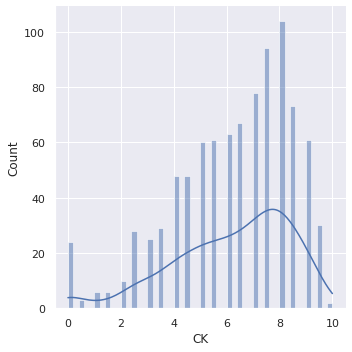

In [7]:
sns.displot(df_score_training['CK'], kde=True, binwidth=.2)

In [8]:
def motions_compare_3m(series):
    """
    Create a dataframe for compare motions value between Mode, Median and Mean Imputation

    User must specify:
        df = the pandas Series (numerical only) the user wants to compare

    Function returns:
        df_compare = a DataFrame imputated value for each imputation methods (Mode, Median and Mean) and origin.
        df_motions = a DataFrame with the motions (mean, var, skew, kurtosis) for comparision of imputation.
    """

    df_compare = pd.DataFrame({
        'origin':series,
        'mode':series.fillna(series.mode()[0]),
        'median':series.fillna(series.median()),
        'mean':series.fillna(series.mean()),
    })

    df_motions = pd.DataFrame({
        'Mean': df_compare.mean(),
        'Variance': df_compare.var(),
        'Skewness': df_compare.skew(),
        'Kurtosis': df_compare.kurtosis()
    })

    return df_compare, df_motions

,Mean,Variance,Skewness,Kurtosis
origin,6.192935,5.009253,-0.758278,0.092283
mode,6.294872,4.900388,-0.847091,0.217133
median,6.210257,4.731413,-0.803081,0.295630
mean,6.192932,4.726377,-0.780543,0.277280


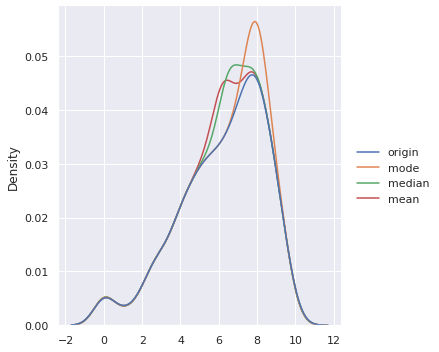

In [9]:
df_compare, df_motion = motions_compare_3m(df_score_training['CK'])

sns.displot(df_compare, kind='kde')
df_motion

### Imputation

In [10]:
# Fillna with mode
# df_score_training['CK'] = df_score_training['CK'].fillna(df_score_training['CK'].mode()[0])

# Fillna with mean
# df_score_training['CK'] = df_score_training['CK'].fillna(df_score_training['CK'].mean())

# Fillna with median
df_score_training['CK'] = df_score_training['CK'].fillna(df_score_training['CK'].median())

# Data Processing


## Analytics

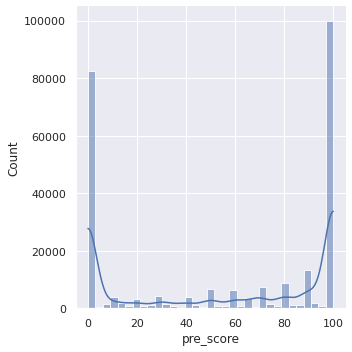

In [11]:
sns.displot(df_wecode['pre_score']/100, kde=True)

The number of pre score in the middle of plot is quite low, most of them is 0 or 100. It's may because the fact that Junior don't really know the right way to print output for problems in the first time. So even they solve the problem right way, it wrong all for the reason of lacking a space.

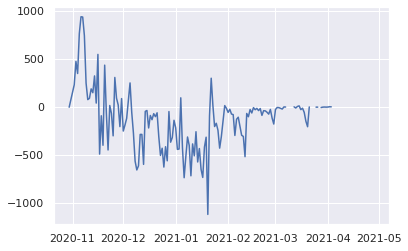

In [12]:
(pd.value_counts(df_wecode.query('pre_score==0')['created_at'].dt.date)-pd.value_counts(df_wecode.query('pre_score==10000')['created_at'].dt.date)).plot()

This plot through time clearly show that the subtraction of submit that have 0 pre_score and 100 pre_score low down after time. So it may not effect on final exam score that much. We will use it for counting of finnished problems.

SCORE                217479
Compilation Error     47113
PENDING                   8
Syntax Error              5
Name: status, dtype: int64

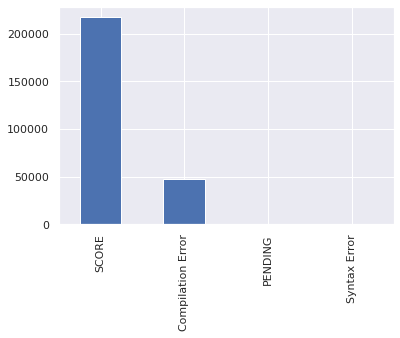

In [13]:
status_count = pd.value_counts(df_wecode['status'])
status_count.plot(kind='bar')
pd.value_counts(df_wecode['status'])

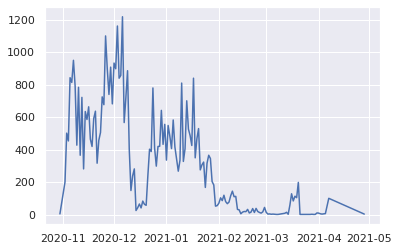

In [14]:
pd.value_counts(df_wecode.query('status=="Compilation Error"')['created_at'].dt.date).plot()

The compilation error is quite a bit related to how careful the student is, because code editor nowadays can detect syntax error real quick. We can clearly see that the graph tend to go down by time. So it may related to the final exam score.

## Data Processing

### Calc: Count number of submission

In [15]:
df_submission_count = pd.DataFrame(
    pd.value_counts(df_wecode['user_id']).reset_index().values,
    columns=["id", "#submission"]
)

### Calc: Count solved problem
(pre_score == 10000)

In [16]:
df_solved_count = pd.DataFrame(
        pd.value_counts(df_wecode.query('pre_score==10000')['user_id']).reset_index().values,
        columns=["id", "#solved"]
)

### Calc: Mean problem solve time

1. Group submission by problem_id and then select the minimum value of created_at field to find out the first submit of each problem

2. Group 100.00 pre_score submission same way to find out first solve time.

3. Inner join above data frames together, so that the unsolved problem will not be included.

4. Calculate by subtracting 2 created_at columns then turn that result into seconds

5. Group by user_id then apply mean function to step 4's result

In [17]:
# Group to find create time of first submission
df_first_submit = df_wecode.groupby(['user_id', 'problem_id']).agg({'created_at':['min']}).reset_index()

# Group to find create time of first solve submission
df_solved = df_wecode.query('pre_score==10000').groupby(['user_id', 'problem_id']).agg({'created_at':['min']}).reset_index()

# Inner Join together, if the problem unsolved will not be included
df_problem_solve_time = df_first_submit.merge(df_solved, how='inner', left_on=['user_id', 'problem_id'], right_on=['user_id', 'problem_id'])

# Calculate by subtract 2 columns and turn it into seconds, then drop them.
df_problem_solve_time['solve_time'] = (df_problem_solve_time['created_at_y']['min'] - df_problem_solve_time['created_at_x']['min']).dt.seconds
df_problem_solve_time = df_problem_solve_time.drop(['created_at_x','created_at_y'], axis=1).droplevel(1, axis=1)

# Group by user_id to calculate mean problem solve time
df_mean_solve_time = df_problem_solve_time.groupby(['user_id']).agg({'solve_time':['mean']})
df_mean_solve_time = df_mean_solve_time.reset_index().droplevel(1, axis=1).rename(columns={
        'solve_time':'mean_solve_time',
        'user_id':'id'
    })

### Calc: Accumulation score
For each **user_id** we **sum up all highest pre_score** of each problem


In [18]:
# Group to find highest pre_score for each problem
df_highest_score = df_wecode.groupby(['user_id', 'problem_id']).agg({'pre_score':['max']}).reset_index()

# Sum up those score by user_id
df_acc_score = df_highest_score.groupby(['user_id']).sum().reset_index().drop(['problem_id'], axis=1)

# Rename columns
df_acc_score = df_acc_score.droplevel(1, axis=1).rename(columns={
    'user_id':'id',
    'pre_score':'acc_score'
})

### Join all data above together

In [19]:
dfs = [df_submission_count, df_solved_count, df_acc_score, df_mean_solve_time]
df_dataset_X = reduce(lambda left,right: pd.merge(left,right,on='id', how='left'), dfs)

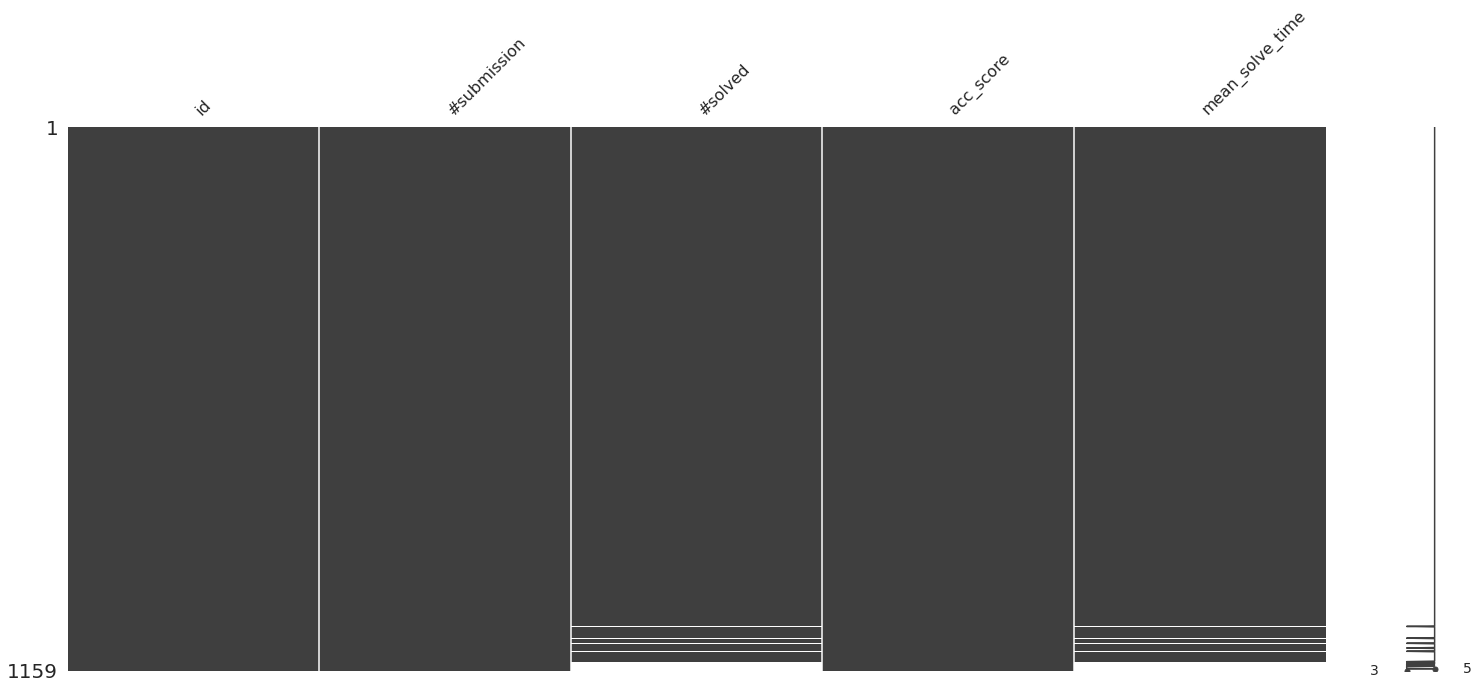

In [20]:
msno.matrix(df_dataset_X)

### Imputation missing data

In process of calculate data above, we missing some data (for e.g: some student may have not done any problem yet, so when we left join those data together, the #solved will be NaN)

In [21]:
# Fill solved na with 0 because they not solve any problem yet
df_dataset_X['#solved'] = df_dataset_X['#solved'].fillna(0)

# Fill mean solve time with min because if not solve any just once it will very low
df_dataset_X['mean_solve_time'] = df_dataset_X['mean_solve_time'].fillna(df_dataset_X['mean_solve_time'].min())

### Calc: Some ralated ratio between above data

In [22]:
# Add some more columns
df_dataset_X['#solved/#submission'] = df_dataset_X['#solved']/df_dataset_X['#submission']
df_dataset_X['acc_score/#submission'] = df_dataset_X['acc_score']/df_dataset_X['#submission']

## Create dataset

### Create
Merge with score and drop **id** feild

In [23]:
df_dataset = pd.merge(df_dataset_X, df_score_training[['id', 'CK']]).drop(['id'], axis=1)

In [24]:
df_dataset

,#submission,#solved,acc_score,mean_solve_time,#solved/#submission,acc_score/#submission,CK
0,1359,274.0,1873888,10501.756757,0.201619,1378.872701,9.0
1,974,240.0,1982888,8699.015385,0.246407,2035.819302,7.5
2,813,126.0,1069000,13619.254717,0.154982,1314.883149,6.5
3,800,177.0,1598169,5101.809211,0.221250,1997.711250,7.5
4,757,207.0,1823888,7691.033333,0.273448,2409.363276,7.5
...,...,...,...,...,...,...,...
848,3,0.0,8947,0.000000,0.000000,2982.333333,8.5
849,2,0.0,0,0.000000,0.000000,0.000000,0.5
850,2,0.0,0,0.000000,0.000000,0.000000,7.5
851,1,0.0,0,0.000000,0.000000,0.000000,8.5


### Scatter plots

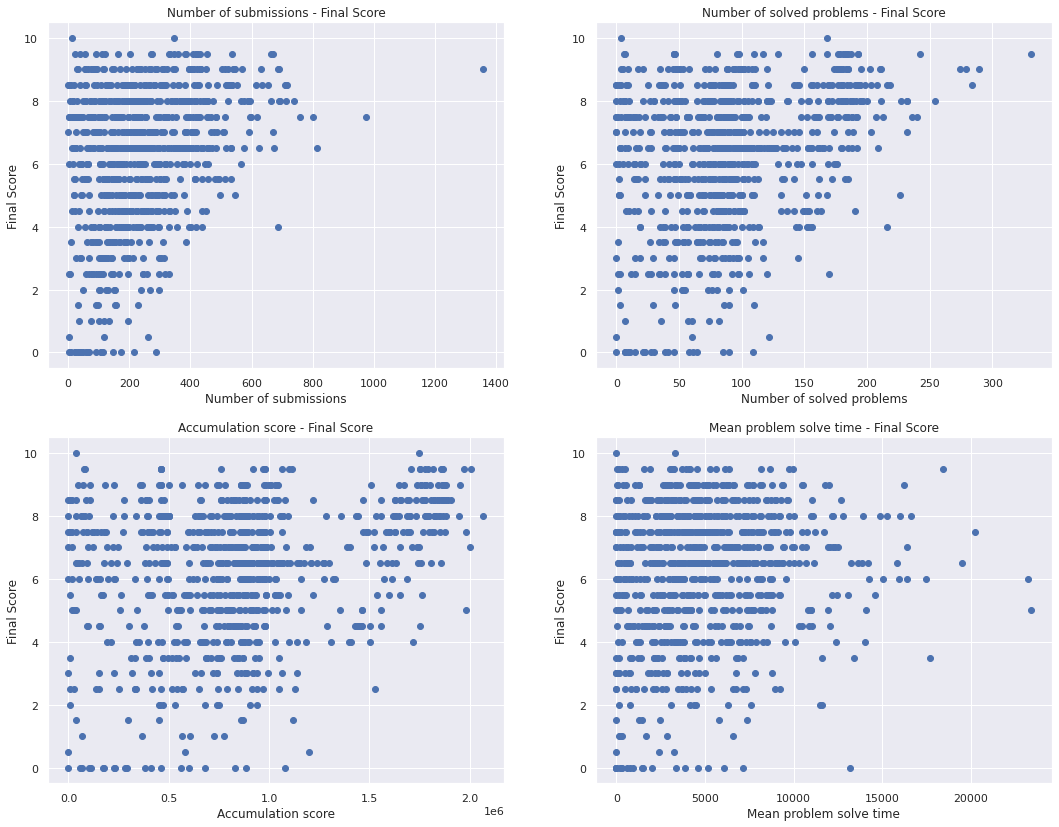

In [25]:
import matplotlib.pyplot as plt
fig, ((axs1, axs2),(axs3, axs4)) = plt.subplots(2,2, figsize = (18,14))

# Number of submissions - Final Score"
axs1.scatter(x = df_dataset['#submission'], y = df_dataset['CK'])
axs1.set_title("Number of submissions - Final Score")
axs1.set(xlabel='Number of submissions', ylabel='Final Score')

# Number of solved problems - Final Score
axs2.scatter(x = df_dataset['#solved'], y = df_dataset['CK'])
axs2.set_title("Number of solved problems - Final Score")
axs2.set(xlabel='Number of solved problems', ylabel='Final Score')

# Accumulation score - Final Score
axs3.scatter(x = df_dataset['acc_score'], y = df_dataset['CK'])
axs3.set_title("Accumulation score - Final Score")
axs3.set(xlabel='Accumulation score', ylabel='Final Score')

# Mean problem solve time - Final Score
axs4.scatter(x = df_dataset['mean_solve_time'], y = df_dataset['CK'])
axs4.set_title("Mean problem solve time - Final Score")
axs4.set(xlabel='Mean problem solve time', ylabel='Final Score')

plt.show()

### Visualize Correlation

In [26]:
df_dataset.corr()

,#submission,#solved,acc_score,mean_solve_time,#solved/#submission,acc_score/#submission,CK
#submission,1.000000,0.856386,0.829941,0.321877,-0.227144,-0.344457,0.323459
#solved,0.856386,1.000000,0.964425,0.124147,0.152788,-0.000719,0.306266
acc_score,0.829941,0.964425,1.000000,0.103779,0.157139,0.065305,0.297189
mean_solve_time,0.321877,0.124147,0.103779,1.000000,-0.345104,-0.390407,0.133851
#solved/#submission,-0.227144,0.152788,0.157139,-0.345104,1.000000,0.949982,-0.142685
acc_score/#submission,-0.344457,-0.000719,0.065305,-0.390407,0.949982,1.000000,-0.170604
CK,0.323459,0.306266,0.297189,0.133851,-0.142685,-0.170604,1.000000


[Text(0, 0.5, '#submission'),
 Text(0, 1.5, '#solved'),
 Text(0, 2.5, 'acc_score'),
 Text(0, 3.5, 'mean_solve_time'),
 Text(0, 4.5, '#solved/#submission'),
 Text(0, 5.5, 'acc_score/#submission'),
 Text(0, 6.5, 'CK')]

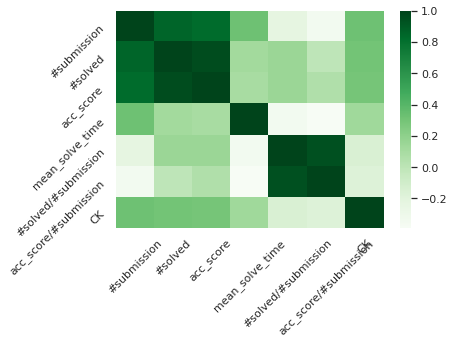

In [27]:
sns.set()
corr_map = sns.heatmap(df_dataset.corr(), cmap='Greens')
corr_map.set_xticklabels(corr_map.get_xticklabels(),rotation=45)
corr_map.set_yticklabels(corr_map.get_yticklabels(),rotation=45)

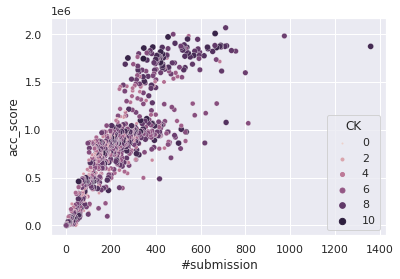

In [28]:
sns.scatterplot(data=df_dataset, x='#submission', y='acc_score', hue='CK', size='CK', sizes=(1, 40))

# Build model



## Separate and scale dataset

In [29]:
scale = StandardScaler()

train, test = train_test_split(df_dataset, test_size=0.3, random_state=20, shuffle=True)
                    
used_feilds = [	'#submission','#solved','acc_score','mean_solve_time','#solved/#submission','acc_score/#submission'	]

train_x = train[used_feilds]
train_y = train['CK']

test_x = test[used_feilds]
test_y = test['CK']

train_x[used_feilds] = scale.fit_transform(train_x[used_feilds].values)
test_x[used_feilds] = scale.fit_transform(test_x[used_feilds].values)

## Metrics

In [30]:
model = Ridge()
model.fit(train_x, train_y)

preds = model.predict(test_x)
print("R2 score : %.2f" % r2_score(test_y,preds))
print("Mean squared error: %.2f" % mean_squared_error(test_y,preds))

R2 score : 0.10
Mean squared error: 3.57


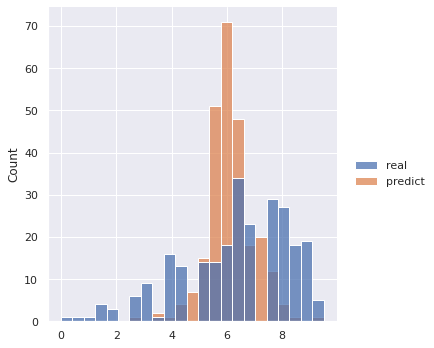

In [31]:
sns.displot(pd.DataFrame({
    'real':test_y,
    'predict':preds,
}))

## Predict final exam score

### Create X Dataframe
**Explaination** In which entry of datasets X if its id does not include in id serials of score table, it will be included.

In [32]:
df_predict = df_dataset_X[~df_dataset_X['id'].isin(df_score_training['id'])]

### Predict

**Why min-max function appear in lambda?**

Well, We realize a weird part of Linear Regression. The more the parameters increase, the more result will increase with no bound.

So for example with user 1772, his (or her) mean solve time is 0, #solve is 0 and #submission is 0 too.
That means our junior just submit for just only 1 time and it doesn't even pass (90%).
Although it is not good at all, it looks quite good for our model. So it returns a beyond great score(11.5).

In [33]:
# Predict score
df_predict['CK'] = model.predict(scale.fit_transform(df_predict[used_feilds].values))

# Round score
df_predict['CK'] = df_predict['CK'].apply(lambda score: max(min(10, round(score*2)/2),0))
df_predict

,id,#submission,#solved,acc_score,mean_solve_time,#solved/#submission,acc_score/#submission,CK
2,1515,828,192.0,1711355,9950.892216,0.231884,2066.853865,8.0
8,1361,714,241.0,1917459,4811.560847,0.337535,2685.516807,9.0
23,1568,654,131.0,1188457,7564.025641,0.200306,1817.212538,7.0
24,559,636,149.0,1433102,3093.625000,0.234277,2253.305031,7.5
25,499,634,148.0,1428166,7440.255474,0.233438,2252.627760,7.5
...,...,...,...,...,...,...,...,...
1145,1814,4,0.0,0,0.000000,0.000000,0.000000,6.0
1151,1039,3,0.0,0,0.000000,0.000000,0.000000,6.0
1152,388,2,0.0,0,0.000000,0.000000,0.000000,6.0
1154,1,2,1.0,10000,0.000000,0.500000,5000.000000,5.0


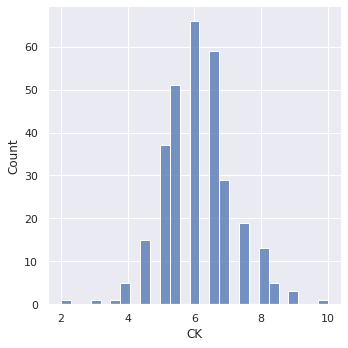

In [34]:
sns.displot(df_predict['CK'])